# Policy gradient algrorithm with BigDL

In [1]:
import random
import gym
import numpy as np
from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
from bigdl.dataset.transformer import Sample
from bigdl.nn.layer import *
from bigdl.util.common import *
from bigdl.optim.optimizer import *
from bigdl.nn.criterion import *

init_engine()
#conf = create_spark_conf()
#conf.setMaster("local[1]")
#sc = SparkContext.getOrCreate(conf)

## The policy gradient agent

In [3]:
class PGAgent:
    def __init__(self, state_size, action_size, gamma=0.95, epsilon=1.0,
                 epsilon_min=0.01, epsilon_decay=0.995, learning_rate=0.001):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = gamma  # discount rate
        self.epsilon = epsilon  # exploration rate
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()

        model.add(Linear(self.state_size, 24))
        model.add(ReLU())

        model.add(Linear(24, 24))
        model.add(ReLU())

        model.add(Linear(24, 1))
        return model

    def act(self, state):
        result = self.model.forward(state)
        return 0 if result < 0 else 1

## Define some utility functions

* from ndarray to RDD

In [4]:
def to_RDD(X, y):
    return sc.parallelize(X).zip(sc.parallelize(y)).map(
            lambda x: Sample.from_ndarray(x[0], x[1]))

* play n episode of games

In [5]:
def play_n_games(n_games=100):
    memory = []
    actions = []
    results = np.array([])
    for e in range(n_games):
        state = env.reset()
        local_memory = np.array([0,0,0,0])
        local_actions = np.array([])
        for time in range(500):
            #env.render()
            local_memory = np.vstack((local_memory, state))
            action = agent.act(state)
            local_actions = np.append(local_actions, action)
            state, _, done, _ = env.step(action)
            if done or time == 498:
                memory.append(local_memory[1:])
                actions.append(local_actions)
                results = np.append(results, time)
                break
    return memory, actions, results

* turn game results into train data (features and labels)

In [6]:
def games_to_train_data(memory, actions, results, benchmark):
    train_batch = np.array([0,0,0,0])
    train_labels = []
    for local_memory, local_actions, result in zip(memory, actions, results):
        train_batch = np.vstack((train_batch, np.array(local_memory)))
        if result > benchmark:
            local_labels = [-1 if x<=0 else 1 for x in local_actions]
        else:
            local_labels = [1 if x<=0 else -1 for x in local_actions]
        train_labels = np.append(train_labels, local_labels)
    return train_batch[1:], train_labels

## initalize simulation environment

In [7]:
env = gym.make('CartPole-v1')

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = PGAgent(state_size, action_size)

[2017-10-25 15:35:23,997] Making new env: CartPole-v1


creating: createSequential
creating: createLinear
creating: createReLU
creating: createLinear
creating: createReLU
creating: createLinear


## train and play

In [8]:
record = []
i = 0
benchmark = 0
local_records = []
exe_times = []

In [9]:
%%time

import timeit

t=0
while i <= 200:
    i += 1
    
    start_of_play = timeit.default_timer()
    memory, actions, results = play_n_games(n_games=50)
    end_of_play = timeit.default_timer()
    
   
    
    record.append([results.mean(), results.var()])
    print('============Current resulst: {}, variance: {}. This is try number: {}==========='.format(results.mean(), results.var(), i))              
    benchmark = results.mean()
    
    exe_time_game_play = end_of_play-start_of_play
    print "game play tooks:",exe_time_game_play,'secs'
    if benchmark != 498:
        t=0
        
        start_of_train = timeit.default_timer()
        
        train_batch, train_labels = games_to_train_data(memory, actions, results, benchmark)
        rdd_sample = to_RDD(train_batch, train_labels)
        
        end_of_data_prepare = timeit.default_timer()
        
        optimizer = Optimizer(model=agent.model,
                                  training_rdd=rdd_sample,
                                  criterion=MSECriterion(),
                                  optim_method=Adam(),
                                  end_trigger=MaxEpoch(1),
                                  batch_size=32)
        trained_model = optimizer.optimize()
        agent.model = trained_model
        end_of_train = timeit.default_timer()
        exe_time_data_prepare = end_of_data_prepare-start_of_train
        exe_time_train = end_of_train-end_of_data_prepare
        print "data prepare tooks:",exe_time_data_prepare,'secs'
        print "train tooks:",exe_time_train,'secs'
    else:
        t+=1
        exe_time_data_prepare = 0
        exe_time_train = 0
        print "no need to train in this trial."
    exe_times.append([exe_time_game_play,exe_time_data_prepare,exe_time_train])
    if t==4:
        break            

============Current resulst: 8.56, variance: 0.6464. This is try number: 1===========
game play tooks: 3.3870549202 secs
creating: createMSECriterion
creating: createAdam
creating: createMaxEpoch
creating: createOptimizer
data prepare tooks: 0.317651033401 secs
train tooks: 2.71863603592 secs
============Current resulst: 8.46, variance: 0.6084. This is try number: 2===========
game play tooks: 3.07830905914 secs
creating: createMSECriterion
creating: createAdam
creating: createMaxEpoch
creating: createOptimizer
data prepare tooks: 0.00994205474854 secs
train tooks: 0.829974889755 secs
============Current resulst: 8.42, variance: 0.4836. This is try number: 3===========
game play tooks: 2.69715189934 secs
creating: createMSECriterion
creating: createAdam
creating: createMaxEpoch
creating: createOptimizer
data prepare tooks: 0.00883507728577 secs
train tooks: 0.726584911346 secs
============Current resulst: 8.56, variance: 0.4464. This is try number: 4===========
game play tooks: 2.84348

data prepare tooks: 0.00670909881592 secs
train tooks: 0.570444107056 secs
============Current resulst: 8.74, variance: 0.3524. This is try number: 29===========
game play tooks: 2.59721207619 secs
creating: createMSECriterion
creating: createAdam
creating: createMaxEpoch
creating: createOptimizer
data prepare tooks: 0.00710201263428 secs
train tooks: 0.847631931305 secs
============Current resulst: 8.26, variance: 0.5524. This is try number: 30===========
game play tooks: 2.46188402176 secs
creating: createMSECriterion
creating: createAdam
creating: createMaxEpoch
creating: createOptimizer
data prepare tooks: 0.00629806518555 secs
train tooks: 0.540333032608 secs
============Current resulst: 8.62, variance: 0.4356. This is try number: 31===========
game play tooks: 2.61962485313 secs
creating: createMSECriterion
creating: createAdam
creating: createMaxEpoch
creating: createOptimizer
data prepare tooks: 0.00682592391968 secs
train tooks: 0.595449209213 secs
============Current resulst:

## plot the score in each try iteration

(48, 2)


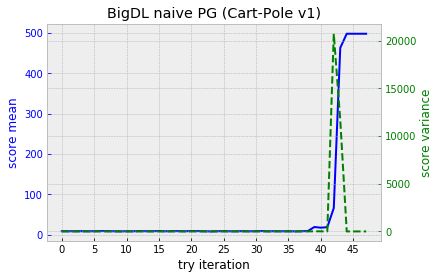

In [19]:
import seaborn
plt.style.use('bmh')
arr = np.asarray(record)
print arr.shape
fig, ax1 = plt.subplots()
ind=np.arange(0,arr.shape[0],1)
#t = np.arange(0.01, 10.0, 0.01)
#s1 = np.exp(t)
ax1.plot(ind,arr[:,0], 'b-')
ax1.set_xlabel('try iteration')
ax1.set_xticks(ind[::5])
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('score mean', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(ind,arr[:,1], 'g--')
ax2.set_ylabel('score variance', color='g')
ax2.tick_params('y', colors='g')
plt.grid(True)
#fig.tight_layout()
plt.title('BigDL naive PG (Cart-Pole v1)');

(48, 3)


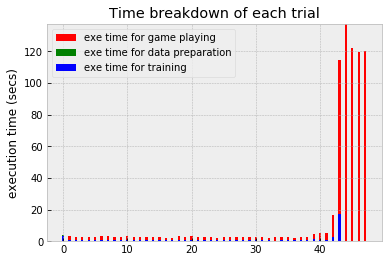

In [28]:
plt.style.use('bmh')
exe_arr = np.asarray(exe_times)
print exe_arr.shape

ind=np.arange(0,arr.shape[0],1)

p1 = plt.bar(ind, exe_arr[:,0], width, color='r')
p2 = plt.bar(ind, exe_arr[:,1], width, color='g',bottom=exe_arr[:,0])
p3 = plt.bar(ind, exe_arr[:,2], width, color='b',bottom=exe_arr[:,1])
             

plt.ylabel('execution time (secs)')
plt.title('Time breakdown of each trial')
#plt.xticks(ind, ('G1', 'G2', 'G3', 'G4', 'G5'))
#plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0],p3[0]), ('exe time for game playing', 'exe time for data preparation','exe time for training'))